In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
from scipy.signal import filtfilt, butter

from scipy.sparse.linalg import LinearOperator, cg, lsqr

import pylops
from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.optimization.sparsity  import *


In [2]:
# EXPERIMENT PARAMS
from pyfrac.hydrafrac.acquisition import recgeom,rec2das_datatrnsfrm,dasgeom

# LOCATION
from pyfrac.pseudodas.receiveroperators import cubePDoperator
from pyfrac.imaging.kirchhoff import Kirchhoff
from pyfrac.utils.localisationutils import get_max_locs

# VISUALISATION
from pyfrac.visualisation.traceviz import traceimage
from pyfrac.visualisation.eventimages import locimage3d

In [3]:
def constantlayers_to_log(vp,interfacedepths,z):
    ''' 
    vp[0] corresponds to velocity of first layer 
    '''
    dz = z[1]
    
    z_old = np.hstack([z[0],interfacedepths,z[-1]])
    f_vp = sc.interpolate.interp1d(z_old, np.hstack([vp,vp[-1]]), kind='previous')
    return f_vp(z)

In [4]:
def smooth_im(im,npix=3):
    smim = filtfilt(np.ones(npix) / npix, 
                   1,
                   filtfilt(np.ones(npix) / npix,
                            1,
                            im.T,
                            method='gust').T,
                   method='gust')
    return smim

# SETUP - MODEL, REC GEOM, SOURCES

In [5]:
# Velocity Model
nx = ny = nz = 200
dx = dy = dz = 5
x, y, z = np.arange(nx)*dx, np.arange(ny)*dy, np.arange(nz)*dz


In [6]:
vp_layers = [1500, 2500, 3500]
interfacedepths = [(nz//4)*dz, (nz//2)*dz]

vp_1D  = constantlayers_to_log(vp_layers,interfacedepths,z)
vp_3L = np.expand_dims(vp_1D, axis=[0])
vp_3L = vp_3L.repeat(nx,axis=0)
vp_3L.shape


# vp_1D  = constantlayers_to_log(vp_layers,interfacedepths,z)
# vp_3L = np.expand_dims(vp_1D, axis=[0,1])
# vp_3L = vp_3L.repeat(ny,axis=1)
# vp_3L = vp_3L.repeat(nx,axis=0)
# vp_3L.shape

(200, 200)

In [7]:
# RECEIVERS
# nxyz = [nx, ny, nz]
# dxyz = [dx, dy, dz]
# gridded_recs, nr, rec_string = recgeom(nxyz, dxyz, nrperfc_xyz=[15])
# print (nr, gridded_recs.shape)

rx = np.arange(2, nx-1,4)
rz = np.ones_like(rx)

recs_gp = np.vstack([rx,rz])
recs = recs_gp*dx 
print(recs.shape)

(2, 50)


In [8]:
rx

array([  2,   6,  10,  14,  18,  22,  26,  30,  34,  38,  42,  46,  50,
        54,  58,  62,  66,  70,  74,  78,  82,  86,  90,  94,  98, 102,
       106, 110, 114, 118, 122, 126, 130, 134, 138, 142, 146, 150, 154,
       158, 162, 166, 170, 174, 178, 182, 186, 190, 194, 198])

In [9]:
# Microseismic sources
sx, sz = [nx//2, int(3*nz//4)]
microseismic = np.zeros((nx, nz))
microseismic[sx, sz] = 1.


# sx, sy, sz = [nx//4, ny//2, int(300/dz)]
# microseismic = np.zeros((nx, ny, nz))
# microseismic[sx, sy, sz] = 1.

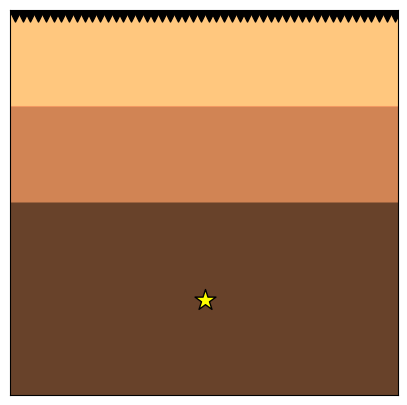

In [10]:
fig,ax = plt.subplots(1,1,figsize=[5,5])
c = ax.imshow(vp_3L.T, aspect='auto', cmap='copper_r', vmax=4500)
# plt.colorbar(c)
ax.scatter(sx,sz,c='yellow', marker='*', s=250, edgecolor='k')
ax.scatter(rx,rz,c='k', marker='v', s=150)
ax.set_xticks([]);
ax.set_yticks([]);

# MAKE DATA

In [11]:
nt = 251
dt = 0.004
t = np.arange(nt)*dt
wav, wavt, wavc = ricker(t[:41], f0=20)

In [12]:
# INITIALISE OPERATOR
Op = Kirchhoff(z=z, 
               x=x, 
               t=t, 
               srcs=recs[:, :1], 
               recs=recs, 
               vel=vp_3L, 
               wav=wav, 
               wavcenter=wavc, 
               mode='eikonal', 
               engine='numba')

# check operator with dottest
_ = dottest(Op, verb=True)

Dot test passed, v^H(Opu)=-3234.801521880451 - u^H(Op^Hv)=-3234.8015218804585


Text(0.5, 1.0, 'Point Receivers')

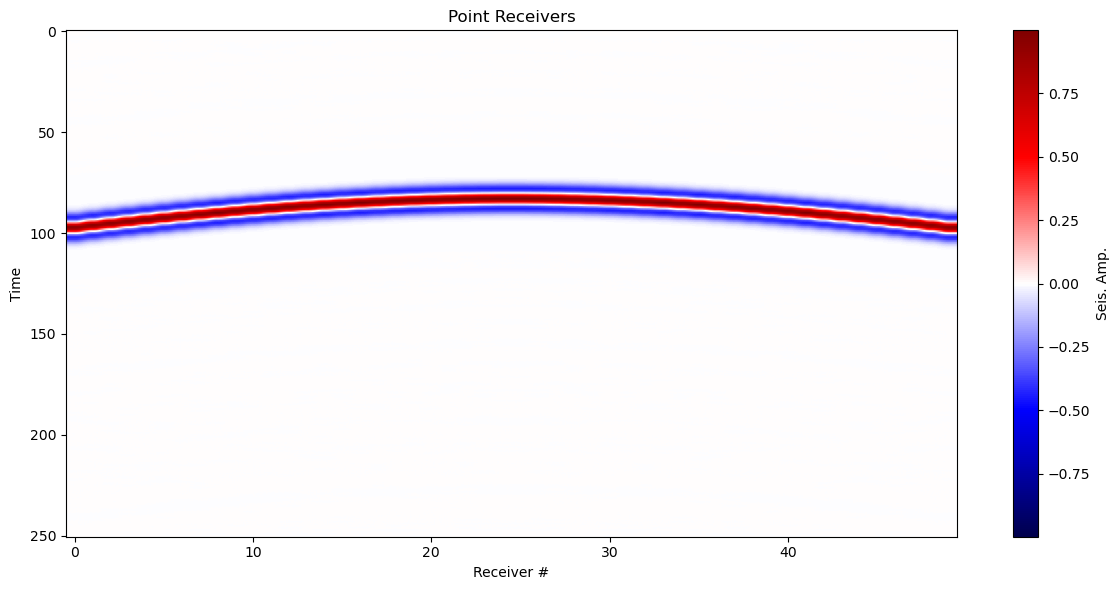

In [13]:
# PERFORM FORWARD (MODEL)
nr = recs.shape[1]
frwddata_1d = Op @ microseismic.flatten().squeeze()
frwddata  = frwddata_1d.reshape(nr,nt)
fig,ax = traceimage(frwddata, climQ=99.99)
ax.set_title('Point Receivers')

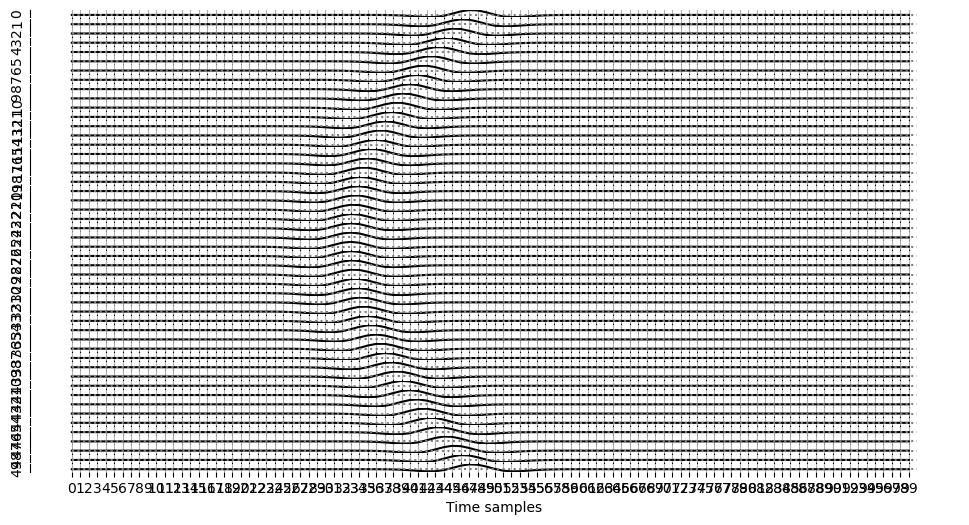

In [14]:
from pyfrac.visualisation.traceviz import wiggleplot
fig,axs = wiggleplot(frwddata[:,50:150])

# MIGRATE

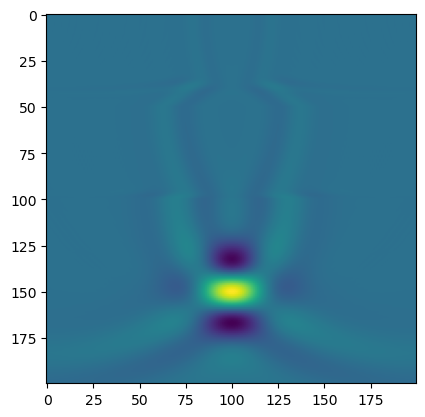

In [15]:
migrated = (Op.H @ frwddata).reshape(nx,nz)
hc =  get_max_locs(migrated, n_max=1, rem_edge=False)
plt.imshow(migrated.T)
# print('Hypo Center:',hc.flatten())
# fig,axs = locimage3d(migrated,sx,sy)

# INVERSION

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 12550 rows and 40000 columns
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =      100
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   1.332e+01  1.332e+01    1.0e+00  1.8e+01
     1 -1.63271e-06   5.461e+00  5.461e+00    4.1e-01  6.6e-01   2.6e+02  1.0e+00
     2 -2.58375e-06   3.577e+00  3.577e+00    2.7e-01  3.9e-01   3.5e+02  2.1e+00
     3 -2.84056e-06   2.745e+00  2.745e+00    2.1e-01  3.0e-01   4.3e+02  3.4e+00
     4 -2.59188e-06   2.159e+00  2.159e+00    1.6e-01  2.1e-01   5.0e+02  5.1e+00
     5 -1.98649e-06   1.718e+00  1.718e+00    1.3e-01  1.9e-01   5.5e+02  6.9e+00
     6 -1.82096e-06   1.436e+00  1.436e+00    1.1e-01  1.4e-01   5.9e+02  8.8e+00
     7 -1.91739e-06   1.227e+00  1.227e+00    9.2e-02  1.3e-01   6.2e+02  1.1e+01
     8 -2.03416e-06   1.113e+00 

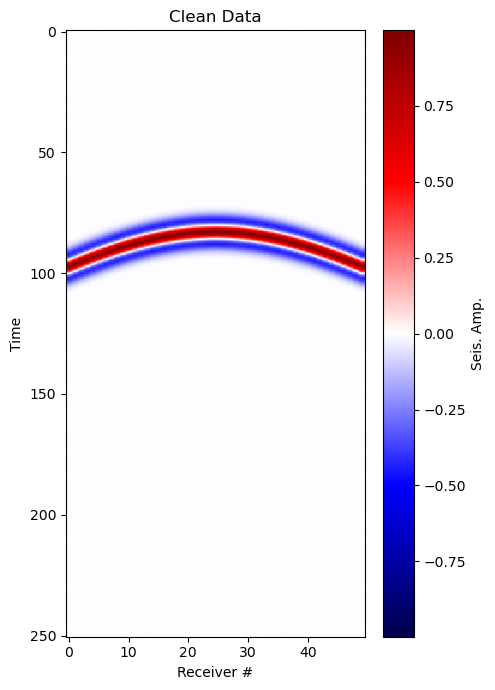

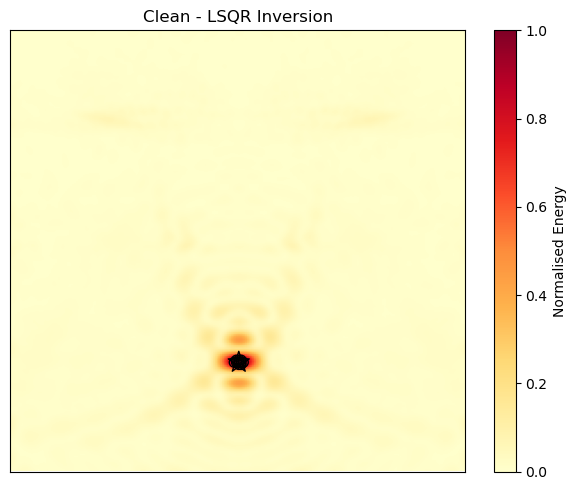

In [16]:
inv = (lsqr(Op, frwddata.ravel(), iter_lim=100, show=True)[0]).reshape(nx,nz)
# hc =  get_max_locs(inv, n_max=1, rem_edge=False)
# print('Hypo Center:',hc.flatten())
fig,ax = traceimage(frwddata, climQ=99.99, figsize=[5,7])
ax.set_title('Clean Data')

smoothed_inv = smooth_im(abs(inv))
loc, locs = get_max_locs(smoothed_inv, n_max=10, rem_edge=True, edgebuf=10)

fig, ax = plt.subplots(1,1,figsize=[6,5])
im = ax.imshow(smoothed_inv.T/np.max(smoothed_inv[10:-10,10:-10]), 
               aspect='auto', cmap='YlOrRd', vmin=0, vmax=1.0)
plt.colorbar(im, label='Normalised Energy')
ax.set_title('Clean - LSQR Inversion')
ax.set_yticks([]); ax.set_xticks([])
ax.scatter(sx,sz, facecolors='none', marker='*', s=250, edgecolor='k')
ax.scatter(locs[0],locs[1], facecolors='none', marker='o', s=50, edgecolor='k')
fig.tight_layout()

# Noisy Data

In [17]:
from synthnoise import add_rig_noise,add_asym_spatiotemporal_noise

In [18]:
wgn = (np.random.random(frwddata.shape)-0.5)
_, cgn = add_asym_spatiotemporal_noise(frwddata)
_, rgn = add_rig_noise(frwddata.T)

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 12550 rows and 40000 columns
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =      100
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   2.653e+01  2.653e+01    1.0e+00  4.5e+00
     1 -2.76956e-06   2.358e+01  2.358e+01    8.9e-01  1.5e-01   2.6e+02  1.0e+00
     2 -5.42141e-06   2.320e+01  2.320e+01    8.7e-01  6.1e-02   3.5e+02  2.1e+00
     3 -8.14692e-06   2.308e+01  2.308e+01    8.7e-01  3.8e-02   4.3e+02  3.5e+00
     4 -1.15285e-05   2.301e+01  2.301e+01    8.7e-01  2.2e-02   5.0e+02  5.2e+00
     5 -1.70575e-05   2.296e+01  2.296e+01    8.7e-01  1.7e-02   5.4e+02  7.1e+00
     6 -2.40682e-05   2.293e+01  2.293e+01    8.6e-01  1.1e-02   5.9e+02  9.1e+00
     7 -3.52967e-05   2.291e+01  2.291e+01    8.6e-01  9.7e-03   6.2e+02  1.1e+01
     8 -4.56821e-05   2.289e+01 

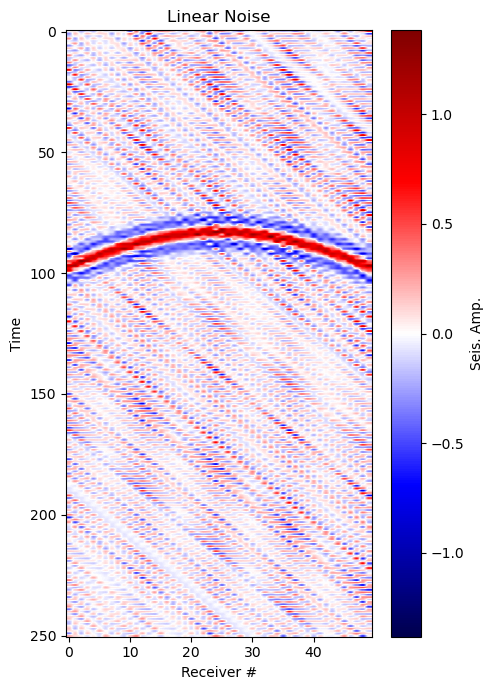

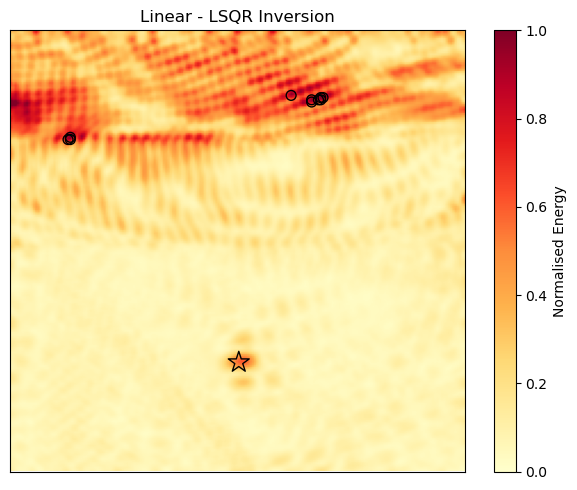

In [25]:
noisy_data = frwddata + 0.25*rgn

fig,ax = traceimage(noisy_data, climQ=99.99, figsize=[5,7])
ax.set_title('Linear Noise')

inv = (lsqr(Op, noisy_data.ravel(), iter_lim=100, show=True)[0]).reshape(nx,nz)

smoothed_inv = smooth_im(abs(inv))
loc, locs = get_max_locs(smoothed_inv, n_max=10, rem_edge=True, edgebuf=10)

fig, ax = plt.subplots(1,1,figsize=[6,5])
im = ax.imshow(smoothed_inv.T/np.max(smoothed_inv[10:-10,10:-10]), 
               aspect='auto', cmap='YlOrRd', vmin=0, vmax=1.0)
plt.colorbar(im, label='Normalised Energy')
ax.set_title('Linear - LSQR Inversion')
ax.set_yticks([]); ax.set_xticks([])
ax.scatter(sx,sz, facecolors='none', marker='*', s=250, edgecolor='k')
ax.scatter(locs[0],locs[1], facecolors='none', marker='o', s=50, edgecolor='k')
fig.tight_layout()

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 12550 rows and 40000 columns
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =      100
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   2.086e+01  2.086e+01    1.0e+00  7.1e+00
     1  6.89248e-06   1.706e+01  1.706e+01    8.2e-01  2.2e-01   2.6e+02  1.0e+00
     2  2.53153e-05   1.650e+01  1.650e+01    7.9e-01  9.3e-02   3.5e+02  2.1e+00
     3  6.34487e-05   1.629e+01  1.629e+01    7.8e-01  6.3e-02   4.2e+02  3.5e+00
     4  1.27975e-04   1.615e+01  1.615e+01    7.7e-01  3.9e-02   5.0e+02  5.4e+00
     5  2.47133e-04   1.603e+01  1.603e+01    7.7e-01  3.0e-02   5.4e+02  7.5e+00
     6  3.74683e-04   1.597e+01  1.597e+01    7.7e-01  2.1e-02   5.9e+02  9.5e+00
     7  5.47221e-04   1.591e+01  1.591e+01    7.6e-01  1.7e-02   6.2e+02  1.2e+01
     8  6.78235e-04   1.588e+01 

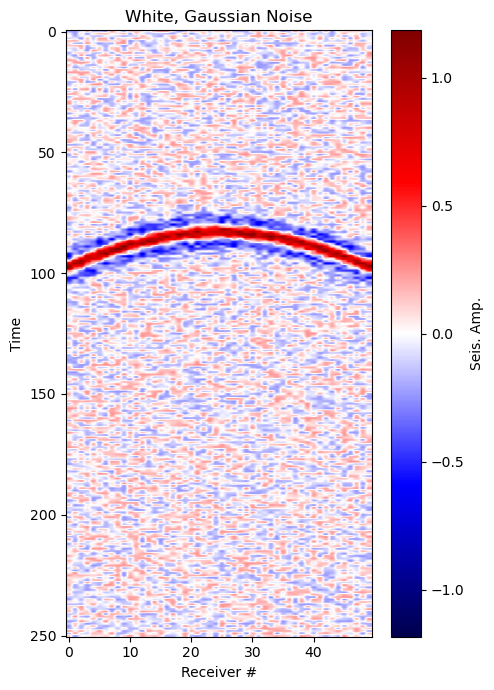

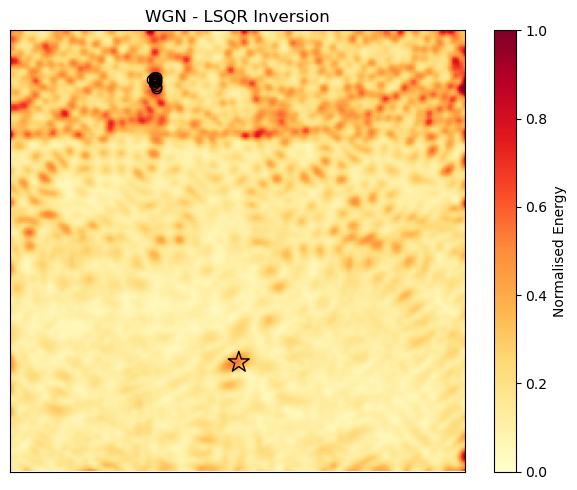

In [24]:
noisy_data = frwddata + 0.5*wgn

fig,ax = traceimage(noisy_data, climQ=99.99, figsize=[5,7])
ax.set_title('White, Gaussian Noise')

inv = (lsqr(Op, noisy_data.ravel(), iter_lim=100, show=True)[0]).reshape(nx,nz)

smoothed_inv = smooth_im(abs(inv))
loc, locs = get_max_locs(smoothed_inv, n_max=10, rem_edge=True, edgebuf=10)

fig, ax = plt.subplots(1,1,figsize=[6,5])
im = ax.imshow(smoothed_inv.T/np.max(smoothed_inv[10:-10,10:-10]), 
               aspect='auto', cmap='YlOrRd', vmin=0, vmax=1.0)
plt.colorbar(im, label='Normalised Energy')
ax.set_title('WGN - LSQR Inversion')
ax.set_yticks([]); ax.set_xticks([])
ax.scatter(sx,sz, facecolors='none', marker='*', s=250, edgecolor='k')
ax.scatter(locs[0],locs[1], facecolors='none', marker='o', s=50, edgecolor='k')
fig.tight_layout()

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 12550 rows and 40000 columns
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =      100
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   1.938e+01  1.938e+01    1.0e+00  8.6e+00
     1 -3.18903e-05   1.472e+01  1.472e+01    7.6e-01  2.9e-01   2.5e+02  1.0e+00
     2 -7.88014e-05   1.383e+01  1.383e+01    7.1e-01  1.4e-01   3.4e+02  2.2e+00
     3 -1.44316e-04   1.340e+01  1.340e+01    6.9e-01  1.0e-01   4.2e+02  3.7e+00
     4 -2.30131e-04   1.308e+01  1.308e+01    6.8e-01  6.7e-02   4.9e+02  5.6e+00
     5 -3.58494e-04   1.280e+01  1.280e+01    6.6e-01  5.4e-02   5.4e+02  7.9e+00
     6 -4.63861e-04   1.263e+01  1.263e+01    6.5e-01  3.7e-02   5.8e+02  1.0e+01
     7 -5.83012e-04   1.251e+01  1.251e+01    6.5e-01  3.1e-02   6.2e+02  1.2e+01
     8 -6.63984e-04   1.244e+01 

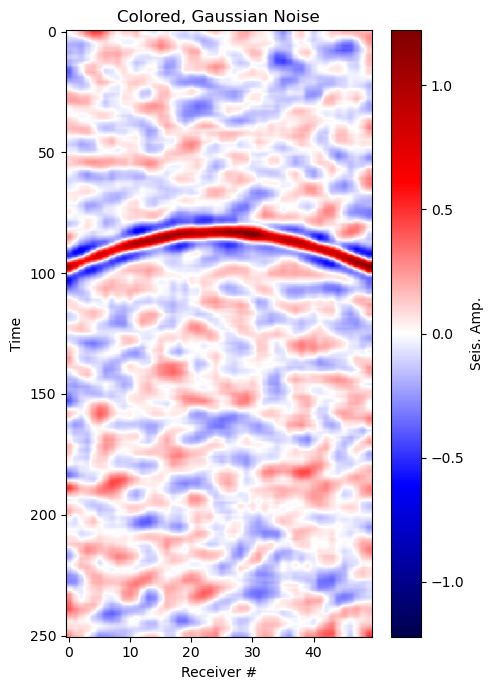

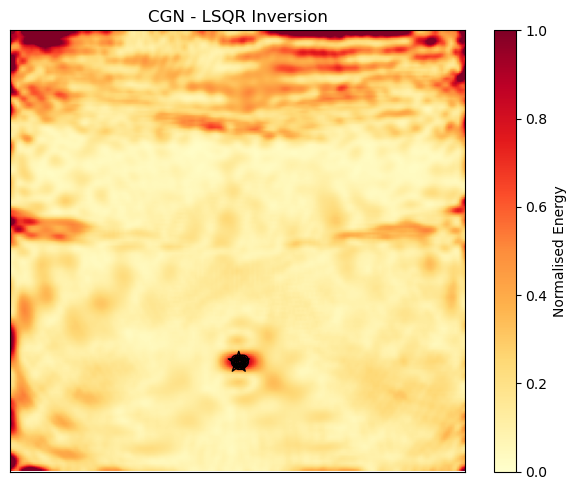

In [23]:
noisy_data = frwddata + 0.5*cgn

fig,ax = traceimage(noisy_data, climQ=99.99, figsize=[5,7])
ax.set_title('Colored, Gaussian Noise')

inv = (lsqr(Op, noisy_data.ravel(), iter_lim=100, show=True)[0]).reshape(nx,nz)

smoothed_inv = smooth_im(abs(inv))
loc, locs = get_max_locs(smoothed_inv, n_max=10, rem_edge=True, edgebuf=10)

fig, ax = plt.subplots(1,1,figsize=[6,5])
im = ax.imshow(smoothed_inv.T/np.max(smoothed_inv[10:-10,10:-10]), 
               aspect='auto', cmap='YlOrRd', vmin=0, vmax=1.0)
plt.colorbar(im, label='Normalised Energy')
ax.set_title('CGN - LSQR Inversion')
ax.set_yticks([]); ax.set_xticks([])
ax.scatter(sx,sz, facecolors='none', marker='*', s=250, edgecolor='k')
ax.scatter(locs[0],locs[1], facecolors='none', marker='o', s=50, edgecolor='k')
fig.tight_layout()